<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Simulation and MCMC
_Author: Matt Brems, Patrick Wales-Dinan_

---

### Learning Objectives
_By the end of the lesson, students should be able to:_
- Solve probability problems given a posterior distribution.
- Describe conjugacy.
- Describe Markov chain Monte Carlo methods.
- Understand how simulation can be used to solve complex problems.

In [24]:
# Import the necessary packages:
import matplotlib.pyplot as plt
import numpy as np

plt.style.use("dark_background")

## Simulations

Simulations are an exceptionally powerful tool used in many areas of data science, including (but not limited to!) Bayesian inference. This is a two-hour crash course in how we can solve problems with simulations.

## Problem 1: Placenta Previa

Our goal is to use Bayesian inference to estimate the proportion of female births among mothers with a condition called placenta previa.

Our parameter of interest is the proportion of female births, $p$.

A common choice for the prior of a proportion is the Beta distribution.
- The Beta distribution is parameterized by $a$ and $b$, much like the Normal distribution is parameterized by $\mu$ and $\sigma$.

Let's plot a Beta distribution with parameters $a = 5$ and $b = 5$, and look at it.

In [25]:
from scipy.stats import beta

In [26]:
def plot_beta(a, b):
    plt.figure(figsize=(12, 9))

    # Generate 100 x values in the appropriate
    # range to use for plotting:
    x = np.linspace(0, 1, 100)

    # Generate line plot.
    plt.plot(x, beta(a, b).pdf(x), "b", lw=2)

    # Plot customization:
    plt.ylabel("Density", fontsize=18)
    plt.xlim((0, 1))
    plt.yticks([])
    plt.xlabel(r"Values of $p$", fontsize=18)
    plt.title(fr"Beta($a={a}$, $b={b}$)", fontsize=24);

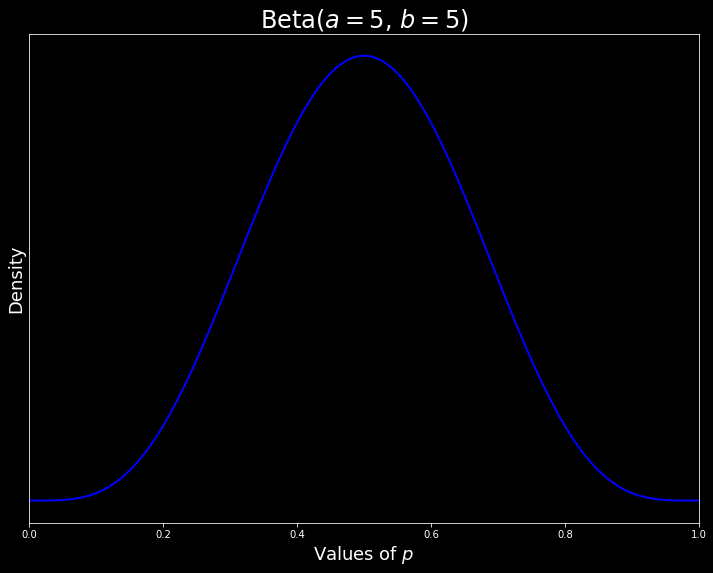

In [27]:
plot_beta(5, 5)

This is a good choice for a prior if I think that $p$ is close to 0.5, that the likeliest value $p$ is exactly 0.5, and if $p$ is bound between 0 and 1.

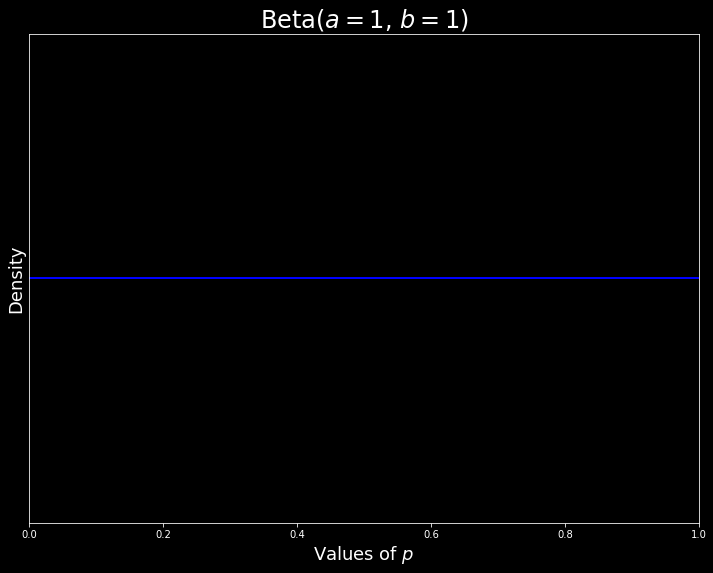

In [28]:
# Let's change this to alpha = 1, & beta = 1

plot_beta(1, 1)

This is a good choice for a prior if the only thing I believe is that $p$ is bound between 0 and 1, but any value is equally likely.
- A Beta(1,1) distribution is exactly identical to a Uniform(0,1) distribution. You can show that the probability density functions are the same!

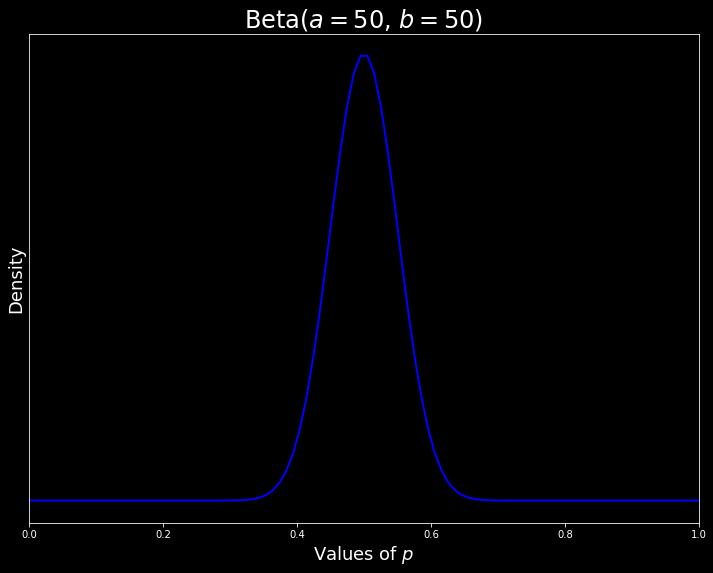

In [29]:
plot_beta(50, 50)

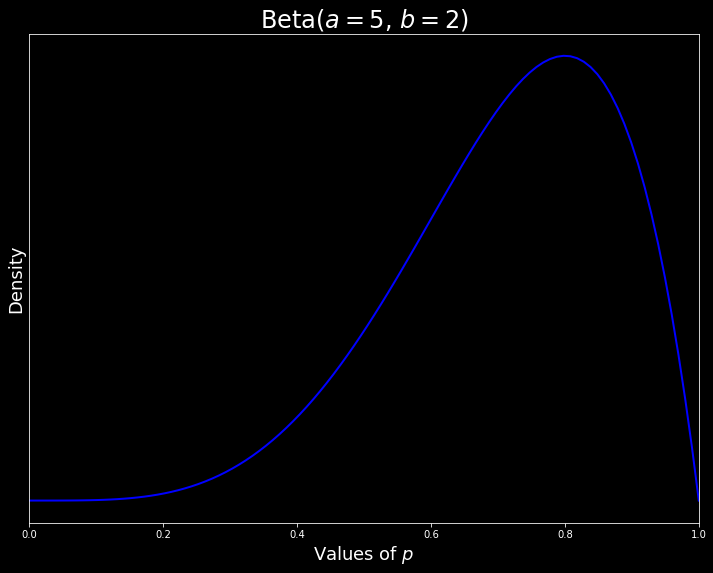

In [30]:
plot_beta(5, 2)

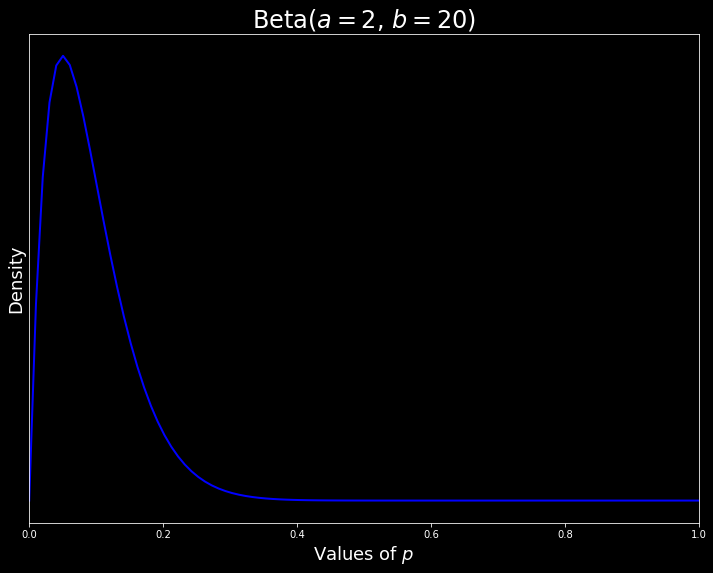

In [31]:
plot_beta(2, 20)

### Likelihood

Our parameter of interest is the proportion of female births, $p$.

A common choice for the likelihood of a proportion is the Binomial, because the data we observe is a series of successes and failures.

We want to construct a likelihood function for $\text{data}|p$. We are saying, "For every possible value of $p$, how likely is it that we observe this data?"

The likelihood function should model how the data are generated.

Suppose I study 980 children and observe exactly 437 female births.

In [32]:
from scipy.stats import binom

In [33]:
def plot_binomial(n_trials, k_successes):

    plt.figure(figsize=(12, 9))

    # Generate 100 x values in the appropriate
    # range to use for plotting:
    x = np.linspace(0, 1, 100)

    # Plot binomial function assuming k_successes in n_trials.
    y = [binom(n=n_trials, p=i).pmf(k_successes) for i in x]

    # Generate line plot.
    plt.plot(x, y)

    # Plot customization:
    plt.ylabel("Likelihood", fontsize=14)
    plt.yticks([])
    plt.xlim((0, 1))
    plt.xlabel(r"Values of $p$", fontsize=14)
    plt.title(
        fr"Binomial likelihood with $n={n_trials}$, $k={k_successes}$", fontsize=18
    );

In [34]:
437 / 980

0.4459183673469388

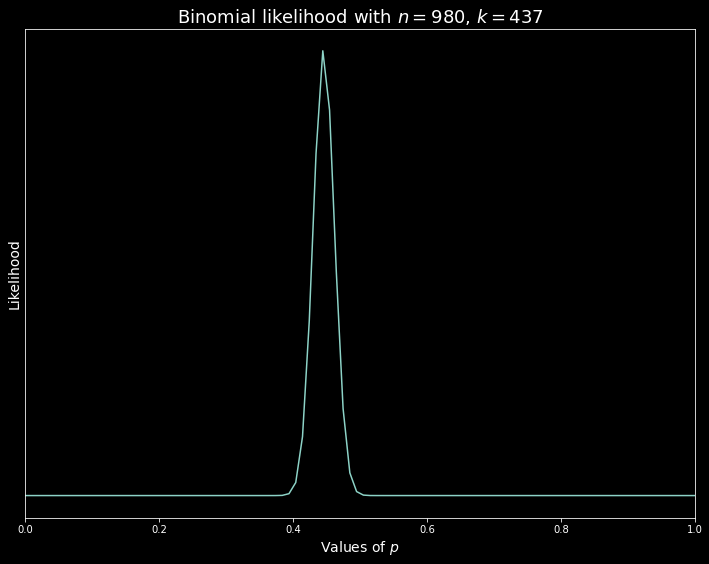

In [35]:
# Suppose I study 980 children and observe
# exactly 437 female births.
plot_binomial(n_trials=980, k_successes=437)

<details><summary>Why do we observe a peak around 0.45 here?</summary>

- Because we examined 980 children and roughly 45% of them were female! It makes sense that the likeliest value for our parameter $p$ is around 45%, since we saw females 45% of the time!
</details>

### Posterior

$$
\begin{eqnarray*}
[\text{posterior}] &\propto& [\text{prior}] \times [\text{likelihood}]
\end{eqnarray*}
$$

In [36]:
def plot_beta_binomial(a, b, n_trials, k_successes, steps=100):
    plt.figure(figsize=(12, 9))

    # Generate 100 x values in the appropriate
    # range to use for plotting:
    lst = np.linspace(0, 1, steps)

    # Calculating prior, likelihood, and posterior.
    prior = [beta(a, b).pdf(i) for i in lst]
    likelihood = [binom(n_trials, i).pmf(k=k_successes) for i in lst]
    posterior = np.multiply(prior, likelihood)

    # Plotting colored lines here to show prior mode, the maximum likelihood value, and posterior mode.
    plt.vlines(
        [
            (a - 1) / (a + b - 2),
            k_successes / n_trials,
            (a + k_successes - 1) / (a + b + n_trials - 2),
        ],
        ymin=0,
        ymax=max(max(prior), max(likelihood), max(posterior)),  # height of dotted lines
        linestyles="dashed",
        colors=["tab:orange", "tab:green", "tab:blue"],
    )

    # Plotting prior, likelihood, and posterior.
    plt.title("Prior, Likelihood, and Posterior", fontsize=24)
    plt.plot(lst, prior, c="tab:orange", label="Prior")
    plt.plot(lst, likelihood, c="tab:green", label="Likelihood")
    plt.plot(lst, posterior, c="tab:blue", label="Posterior")

    plt.xticks(fontsize=16)
    plt.yticks([])

    # Control y limits.
    plt.ylim(
        0, max(max(likelihood), max(posterior)) * 1.1
    )  # You can comment this out to see it all on 1 plot.

    plt.legend(fontsize=18);

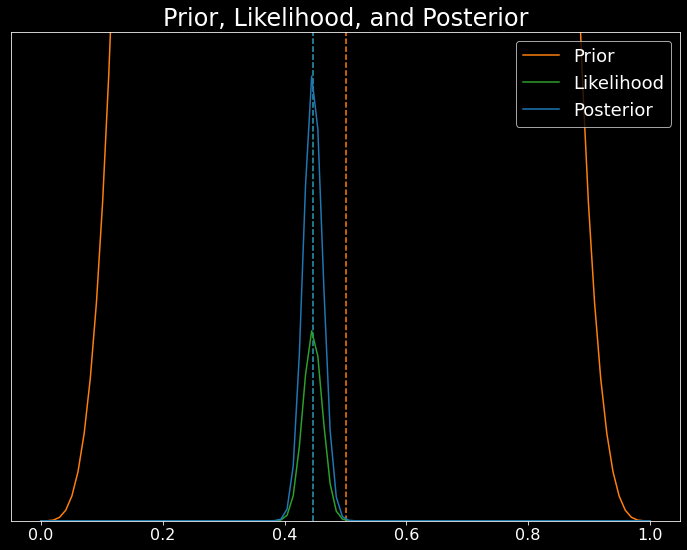

In [37]:
plot_beta_binomial(
    a=5,  # Hyperparameter a for Beta(a, b)
    b=5,  # Hyperparameter b for Beta(a, b)
    n_trials=980,  # Hyperparameter n for Binomial(n, k)
    k_successes=437,
)  # Hyperparameter k for Binomial(n, k)

## Find our answer using simulations!

Before we had computers to do this heavy lifting for us, we would have literally needed to multiply these probability distributions together.

$$
\begin{eqnarray*}
Beta(a,b) &=& \frac{(a + b - 1)!}{(a-1)!(b-1)!}p^{a-1}(1-p)^{b-1} \\
Binomial(n,p) &=& \frac{n!}{(n-k)!}p^{k}(1-p)^{n-k} \\
\Rightarrow Beta(a + \text{# of successes}, b + \text{# of failures}) &=& \frac{((a + k) + (b + (n - k)) - 1)!}{((a + k) - 1)!((b + (n - k) - 1)!}p^{(a + k) - 1}(1 - p)^{b + (n - k) -1}
\end{eqnarray*}
$$

One could show that, in our placenta previa example, if we pick a Beta(5, 5) prior and a Binomial likelihood with 437 successes out of 980 observations, then our posterior is **exactly** a Beta(442, 548) distribution. (There's a [YouTube video proof here](https://www.youtube.com/watch?v=hKYvZF9wXkk).)
- This is a property called **conjugacy**.
- When the prior and the posterior follow the same named distribution (e.g. Beta), we say that the likelihood is conjugate for the prior.
- This simplifies our work! We rely on the math "results" proven by other people.

Our goal is to use Bayesian inference to estimate the proportion of female births among mothers with a condition called placenta previa.

In [38]:
# Generate 100,000 values from a Beta(442, 548).
sims = beta(442, 548).rvs(size=100_000, random_state=42)

### 1. What is the probability that our proportion of female births is below 0.5?

In [39]:
sims

array([0.45371915, 0.44614664, 0.45673139, ..., 0.45347484, 0.44654172,
       0.43751   ])

In [40]:
(sims < 0.5).mean()

0.99968

### 2. What is the probability that our proportion of female births among mothers with placenta previa is between 0.44 and 0.46?

In [41]:
((sims < 0.46) & (sims > 0.44)).mean()  # Jessics's code

0.46329

In [42]:
np.mean((sims >= 0.44) & (sims <= 0.46))  # Albert's Code

0.46329

### 3. What is a 95% credible interval for the proportion of female births?

In [43]:
np.percentile(sims, [0.025, 0.975])

array([0.39290175, 0.4095921 ])

<details><summary>How would we interpret this credible interval?</summary>

<ul>
<li>There is a 95% chance that the proportion of female births among mothers with placenta previa is between 39.29% and 40.96%.</li>
    </ul>
</details>

<details><summary>Why did we randomly simulate numbers instead of using the .pdf() or .cdf() methods of our Beta function?</summary>
    
<ul>
<li> Because I picked a Beta prior and Binomial likelihood, I knew things would work out nicely. But things don't always work out nicely!</li>
    
<li>If I picked, for example, a Beta prior and a Poisson likelihood, my posterior wouldn't be a Beta distribution.</li>
    
<li>A table of conjugate priors and likelihoods can be found here: https://en.wikipedia.org/wiki/Conjugate_prior#Table_of_conjugate_distributions.</li>
</ul>
</details>

## Problem 2: Estimating Pi (and other Areas under the Curve)

We can generate random numbers to estimate the value of $\pi$ using [Monte Carlo simulations](https://en.wikipedia.org/wiki/Monte_Carlo_method). Monte Carlo simulations are a powerful way for us to model complex systems by generating random numbers!

- The area of a circle is given by $\pi r^2$, where $r$ is the radius (or half-distance) of the circle.
- The area of a square is given by $s^2$, where $s$ is the length of one side of the square.

<img src="../images/circle_square.png" alt="drawing" width="275"/>

- If we place a circle inside a square like above, then the side length of the square $s$ is exactly $2r$.
- If we calculate the area of the circle divided by the area of the square, we get:

$$
\begin{eqnarray*}
\frac{\text{area of circle}}{\text{area of square}} &=& \frac{\pi r^2}{s^2} \\
\\
&=& \frac{\pi r^2}{4 r^2} \\
\\
&=& \frac{\pi}{4}
\end{eqnarray*}
$$

Let's pretend like we're sprinking grains of sand all over the circle and square by generating random numbers, then track how much sand falls inside the circle compared to the square.

<img src="../images/pi_estimation.gif" alt="drawing" width="400"/>

In [44]:
# Set a seed.
np.random.seed(42)

# Spread grains of sand.
x = np.random.uniform(0, 1, 25_000_000)
y = np.random.uniform(0, 1, 25_000_000)

In [45]:
x[1000], y[1000]

(0.18513292883861965, 0.058266491171822365)

In [46]:
# Check if each grain of sand is inside the circle.

# Start counter at 0.
count = 0

# Iterate through each grain of sand.
for i in range(len(x)):

    # Check to see if each grain of sand is inside the circle.
    if x[i] ** 2 + y[i] ** 2 <= 1:

        # If so, add one to count.
        count += 1

In [48]:
# Check sand in circle divided by sand in square.
count / len(x)

0.78550072

$$
\begin{eqnarray*}
\frac{\text{area of circle}}{\text{area of square}} &=& \frac{\pi}{4} \\
\Rightarrow \frac{\text{sand in circle}}{\text{sand in square}} &\approx& \frac{\pi}{4} \\
\Rightarrow 4 \times \frac{\text{sand in circle}}{\text{sand in square}} &\approx& \pi \\
\end{eqnarray*}
$$

In [49]:
# Multiply by four.
count / len(x) * 4

3.14200288

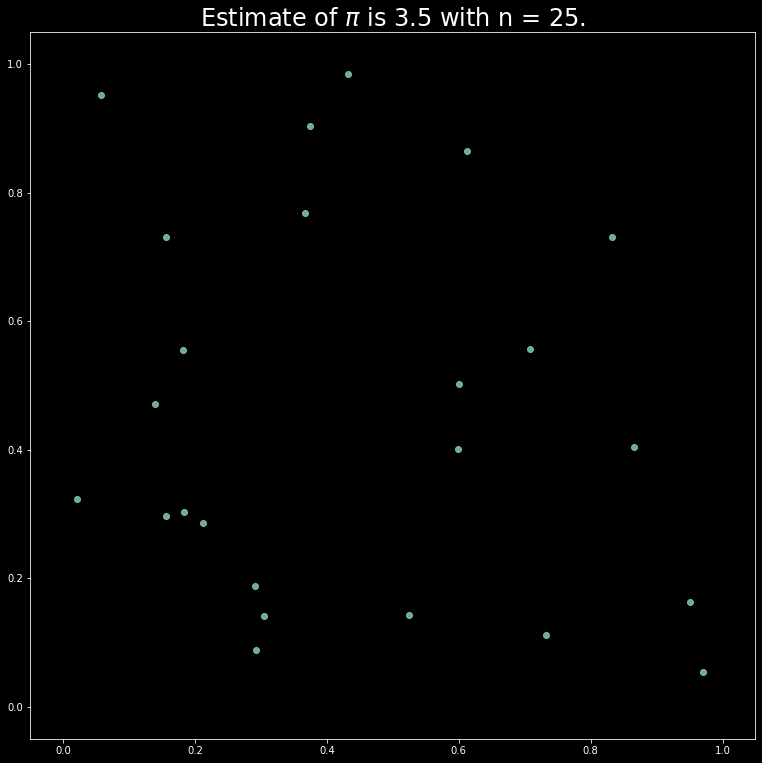

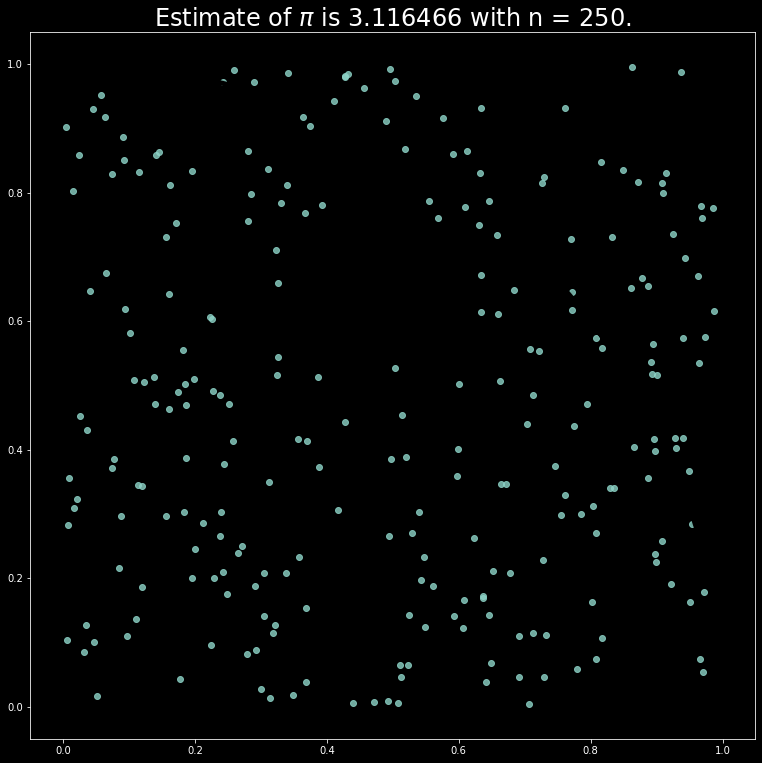

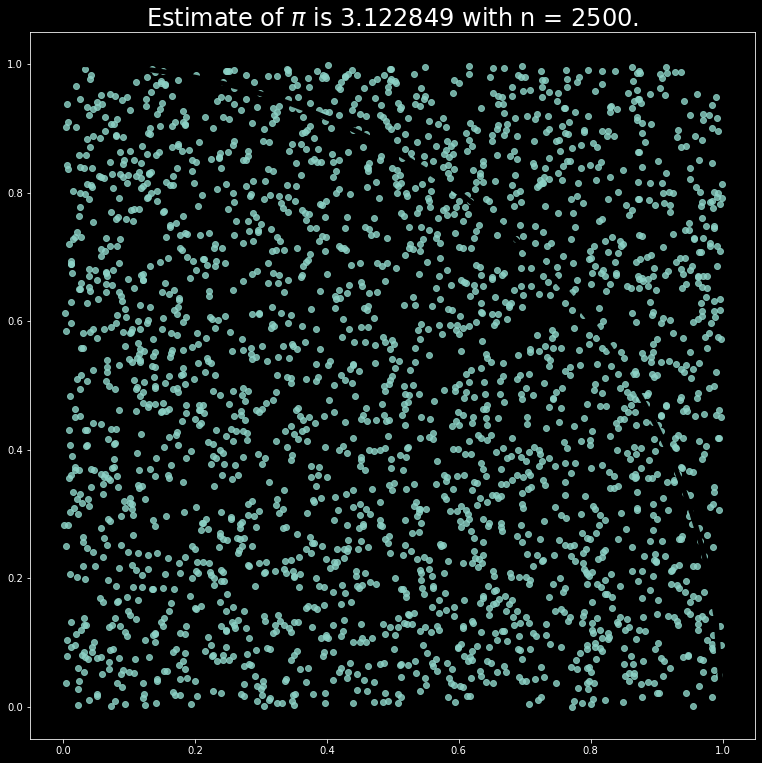

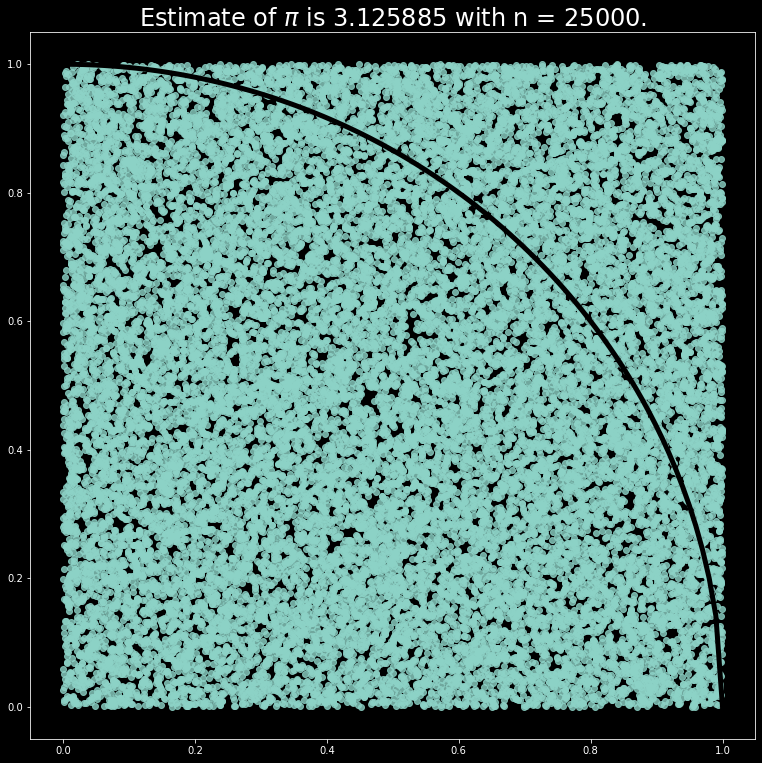

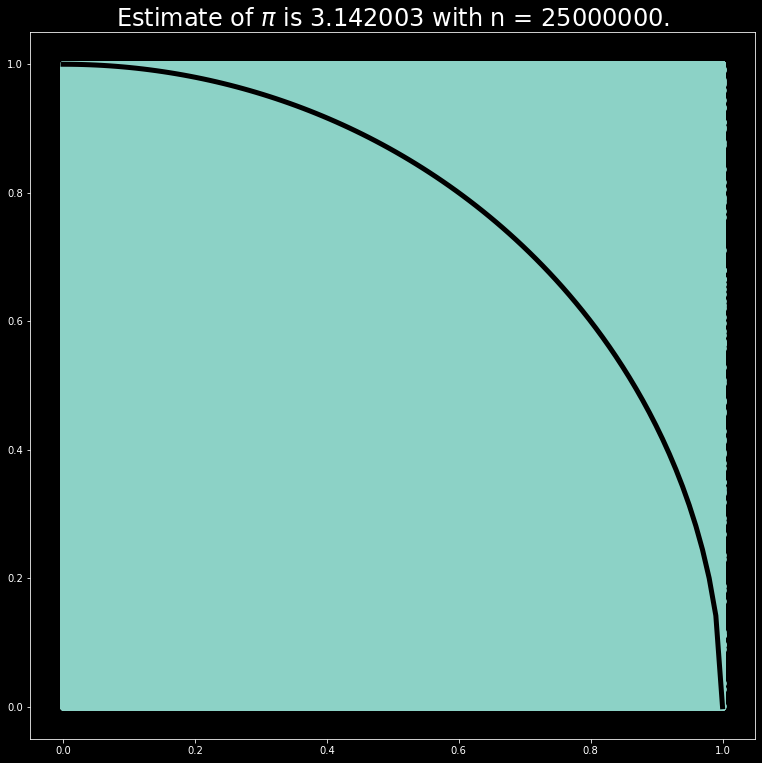

In [50]:
# Start counter at 0.
count = 0

# What horizontal axis values are we plotting?
horiz = np.linspace(0, 1, 100)

# Iterate through each grain of sand.
for i in range(len(x)):

    # Check to see if each grain of sand is inside the circle.
    if x[i] ** 2 + y[i] ** 2 <= 1:

        # If so, add one to count.
        count += 1

    if (i + 1) in [25, 250, 2_500, 25_000, 25_000_000]:
        # Set figure size.
        plt.figure(figsize=(13, 13))

        # Plot line of circle: x^2 + y^2 = 1
        plt.plot(
            horiz,  # horizontal axis values
            [np.sqrt(1 - x_i ** 2) for x_i in horiz],  # height of function values
            lw=5,  # line width = 5
            color="k",
        )  # change it to black

        # Generate scatterplot of points.
        plt.scatter(
            x[:i],  # horizontal location of dot
            y[:i],  # vertical location of dot
            alpha=0.8,
        )  # transparency of dot (make it 60% transparent, 40% solid)

        plt.title(
            fr"Estimate of $\pi$ is {round(4 * count / i,6)} with n = {i + 1}.",
            fontsize=24,
        );

Monte Carlo simulations are used to model much more complicated things as well. In calculus, if you remember calculating the integral (area under the curve), you had to remember those nasty "integration by parts" formulas and "u-substitution." Monte Carlo simulations make that [relatively trivial with computers](https://www.youtube.com/watch?v=GZXhGwCXct0)!

You may remember that we discussed Monte Carlo simulations all the way back in the Introduction to Probability lesson. Some of the problems in the notebook included "Suppose you roll three dice. What is the probability that the three dice are rolled in increasing order?" and "I flip my coin until I flip heads. I count up the number of coins I flipped and roll that many dice. What is the probability that the average roll will be between 3 and 4 (inclusive)?"
- These might be good probability problems to practice!

Monte Carlo simulations aren't inherently Bayesian by themselves. But the way that `PyMC3` and most programs will find the posterior distribution of the parameter of interest will be to use Markov Chain Monte Carlo methods, or MCMC methods.

## Primer on Markov Chain Monte Carlo Methods

Here's a quick, three-minute run-down of Markov Chain Monte Carlo methods.

There are three main components to MCMC Methods.
- Monte Carlo Methods
- Markov Chains
- Acceptance-Rejection Sampling

If we were to just generate random numbers without any rhyme or reason, we'd be doing basic Monte Carlo simulations.
<img src="../images/montecarlo.gif" alt="drawing" width="500"/>

Suppose that, instead, we're still generating random numbers. However, this time, the last random number we generate influences the next random number we generate. This incorporates Markov chains.
<img src="../images/markovchain.gif" alt="drawing" width="600"/>

The final component, "acceptance-rejection sampling," will take each random sample and accept it or reject it, based on how "good" it is. The algorithm for doing this uses the prior and likelihood that you came up with to determine if this sample is "good enough." The basic algorithm is called the [Metropolis-Hastings Algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).

<img src="../images/acceptancerejection.gif" alt="drawing" width="550"/>

All of this will happen when you run `pymc3.sample()` later!

## ---
There are three main components to MCMC Methods.
- Monte Carlo Methods
- Markov Chains
- Acceptance-Rejection Sampling

### Acceptance-Rejection Sampling

- Acceptance-rejection sampling is a specific type of Monte Carlo sampling.

- We’re going to sample some observation, then decide whether to keep it (accept it) or discard it (reject it). 
    - Specifically, we will accept these values a certain percentage of the time and reject a certain percentage of the time.

- As our random walk moves about, we need some way to make sure that we’re moving in the right direction.
    - If we are moving in the right direction, we’ll accept that sample.
    - If we aren’t moving in the right direction, we may reject that sample.

We’ll walk through a specific algorithm to accept/reject, called the [Metropolis-Hastings algorithm](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm).
- PyMC by default will implement a more sophisticated algorithm called the [No U-Turn Sampler](https://arxiv.org/abs/1111.4246).

The Metropolis-Hastings algorithm allows us to, at each step, identify whether we are getting “hotter” or “colder.”

#### Metropolis-Hastings Algorithm
Part 1. Generate $\theta_{proposal} \sim N(\theta_{t-1}, \sigma)$.

Part 2. Calculate the ratio of posterior probabilities $r = \frac{P(\theta_{proposal}|y)}{P(\theta_{t-1}|y)}$.
- Since we have specified the prior and the likelihood, we can just find the posterior probability of these specific values!
- If $r \ge 1$, then $\theta_{proposal}$ is a likelier value for our posterior distribution than $\theta_{t-1}$. You can think of this as "we're heading in the right direction."
- If $r < 1$, then $\theta_{proposal}$ is not a likelier value for our posterior distribution than $\theta_{t-1}$. You can think of this as "we're heading in a direction of lower probability."

Part 3. Calculate our acceptance probability $\alpha = \min\{r,1\}$.
- This is the probability that we'll accept $\theta_{proposal}$ as our new value $\theta_t$.
- If $r \ge 1$, then $\theta_{proposal}$ is a likelier value for our posterior distribution than $\theta_{t-1}$ and our acceptance probability is 100%!
- If $r < 1$, then $\theta_{proposal}$ is not a likelier value for our posterior distribution than $\theta_{t-1}$, so we may reject $\theta_{proposal}$.

Part 4. We want to get our computer to basically flip a coin with probability of success $\alpha$ to determine whether or not we accept $\theta_{proposal}$. We generate $U_t \sim Uniform(0,1)$.
- If $U_t \le \alpha$, then accept $\theta_{proposal}$. (That is, $\theta_t = \theta_{proposal}$.)
- If $U_t > \alpha$, then reject $\theta_{proposal}$. (That is, $\theta_t = \theta_{t-1}$.)

Remember that we've already seen how Markov chains and Monte Carlo simulations can work together. Let's add the acceptance/rejection component to this!


We will repeat this process a large number of times - the number of samples we generate with `pm.sample()`.

Once we do this long enough and visually inspect traceplots to convince ourselves that we have “converged” to the posterior distribution of interest, we usually discard early samples (before we converged), then we store some large $n$ of the later samples.
- We might run this multiple times (by setting `chains` > 1 in `PyMC`) to protect against converging to a local optimum.

Once we have our sample of size $n$, we can conduct whatever inference we want on the posterior distribution of the parameter of interest.
- Find the mean.
- Find the median.
- Find the 95% ‘highest posterior density.’
- Find the variance.

## Problem 3: Who will win the election?

Our final simulation-based problem is going to be a fairly advanced simulation problem, and it has to do with forecasting [the 2020 Presidential election](https://www.nytimes.com/interactive/2016/upshot/presidential-polls-forecast.html).

<img src="../images/electoralvotes.png" alt="drawing" width="700"/>

Political forecasts (like many forecasts) are done through Monte Carlo simulations.

In [51]:
prob_biden = {
    "DC": 0.995,
    "CA": 0.995,
    "MD": 0.995,
    "HI": 0.995,
    "VT": 0.995,
    "NY": 0.995,
    "RI": 0.995,
    "IL": 0.995,
    "WA": 0.995,
    "NJ": 0.995,
    "CT": 0.995,
    "ME-CD1": 0.995,
    "DE": 0.995,
    "MA": 0.995,
    "OR": 0.98,
    "VA": 0.96,
    "NM": 0.95,
    "MI": 0.94,
    "MN": 0.94,
    "NH": 0.92,
    "ME": 0.91,
    "CO": 0.89,
    "PA": 0.75,
    "WI": 0.75,
    "NV": 0.68,
    "GA": 0.495,
    "FL": 0.495,
    "NC": 0.495,
    "AZ": 0.495,
    "NE-CD2": 0.475,
    "OH": 0.46,
    "IA": 0.38,
    "ME-CD2": 0.36,
    "UT": 0.27,
    "AK": 0.17,
    "MS": 0.14,
    "SC": 0.1,
    "TX": 0.04,
    "IN": 0.03,
    "MO": 0.02,
    "LA": 0.02,
    "MT": 0.01,
    "NE-CD1": 0.01,
    "WV": 0.005,
    "TN": 0.005,
    "ND": 0.005,
    "KS": 0.005,
    "AL": 0.005,
    "AR": 0.005,
    "NE": 0.005,
    "SD": 0.005,
    "ID": 0.005,
    "KY": 0.005,
    "OK": 0.005,
    "WY": 0.005,
    "NE-CD3": 0.005,
}

In [52]:
electoral_votes = {
    "DC": 3,
    "CA": 55,
    "MD": 10,
    "HI": 4,
    "VT": 3,
    "NY": 29,
    "RI": 4,
    "IL": 20,
    "WA": 12,
    "NJ": 14,
    "CT": 7,
    "ME-CD1": 1,
    "DE": 3,
    "MA": 11,
    "OR": 7,
    "VA": 13,
    "NM": 5,
    "MI": 16,
    "MN": 10,
    "WI": 10,
    "ME": 2,
    "PA": 20,
    "CO": 9,
    "NH": 4,
    "NV": 6,
    "FL": 29,
    "NC": 15,
    "OH": 18,
    "IA": 6,
    "ME-CD2": 1,
    "UT": 6,
    "NE-CD2": 1,
    "AK": 3,
    "GA": 16,
    "AZ": 11,
    "MS": 6,
    "SC": 9,
    "TX": 38,
    "IN": 11,
    "MO": 10,
    "LA": 8,
    "MT": 3,
    "NE-CD1": 1,
    "WV": 5,
    "TN": 11,
    "ND": 3,
    "KS": 6,
    "AL": 9,
    "AR": 6,
    "NE": 2,
    "SD": 3,
    "ID": 4,
    "KY": 8,
    "OK": 7,
    "WY": 3,
    "NE-CD3": 1,
}

In [53]:
# Simulate one election in Ohio.

np.random.choice(["Biden", "Trump"], p=[prob_biden["OH"], 1 - prob_biden["OH"]])

'Trump'

In [54]:
# Simulate one election across the U.S.

# Set up electoral vote counter.
biden_ev = 0
trump_ev = 0

# Iterate through each state.
for state in prob_biden.keys():
    
    # Who wins the election in that state?
    state_winner = np.random.choice(
        ["Biden", "Trump"], p=[prob_biden[state], 1 - prob_biden[state]]
    )

    # If the winner is Biden, award him the electoral votes.
    if state_winner == "Biden":
        biden_ev += electoral_votes[state]

    # Otherwise, award Trump the electoral votes.
    else:
        trump_ev += electoral_votes[state]

if biden_ev >= 270:
    print(f"Biden wins the election with {biden_ev} electoral votes.")

elif trump_ev >= 270:
    print(f"Trump wins the election with {trump_ev} electoral votes.")

else:
    print(
        f"Biden earned {biden_ev} electoral votes and Trump earned {trump_ev} electoral votes. Onto the House!"
    )

Biden wins the election with 314 electoral votes.


In [57]:
# Simulate 10,000 elections across the U.S.

np.random.seed(2020)

ev_totals = []

for election in range(10_000):

    if election % 1_000 == 0:
        print(f"On election {election} out of 10,000")

    # Set up electoral vote counter.
    biden_ev = 0
    trump_ev = 0

    # Iterate through each state.
    for state in prob_biden.keys():
        
        # Who wins the election in that state?
        state_winner = np.random.choice(
            ["Biden", "Trump"], p=[prob_biden[state], 1 - prob_biden[state]]
        )

        # If the winner is Biden, award him the electoral votes.
        if state_winner == "Biden":
            biden_ev += electoral_votes[state]

        # Otherwise, award Trump the electoral votes.
        else:
            trump_ev += electoral_votes[state]

    ev_totals.append(biden_ev)

On election 0 out of 10,000
On election 1000 out of 10,000
On election 2000 out of 10,000
On election 3000 out of 10,000
On election 4000 out of 10,000
On election 5000 out of 10,000
On election 6000 out of 10,000
On election 7000 out of 10,000
On election 8000 out of 10,000
On election 9000 out of 10,000


In [58]:
len(ev_totals)

10000

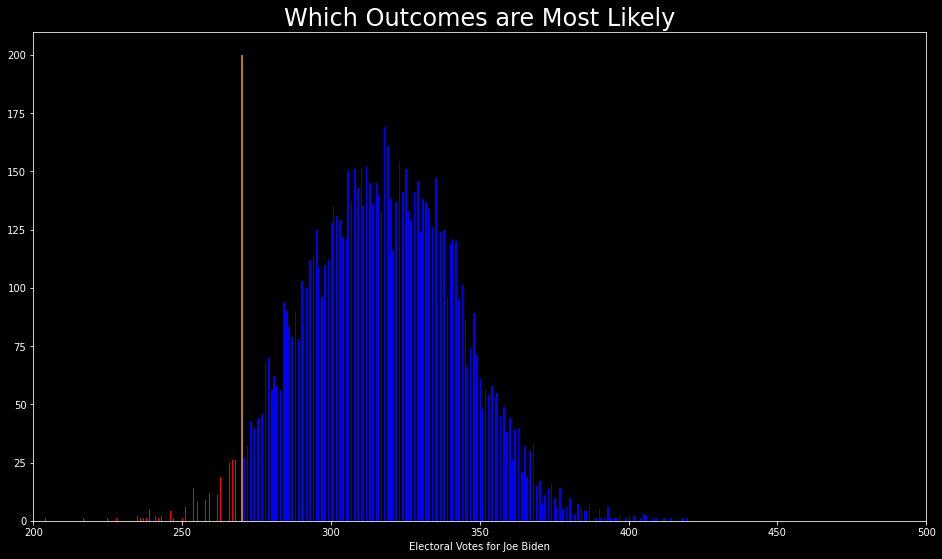

In [59]:
# Generate plot.

plt.figure(figsize=(16, 9))

ev_totals = np.array(ev_totals)

# Generate blue histogram for Biden victory, red histogram for Trump victory.
plt.hist(ev_totals[ev_totals >= 270], color="blue", bins=270)
plt.hist(ev_totals[ev_totals < 269], color="red", bins=270)

# Plot a line for a tie.
plt.vlines(x=270, ymin=0, ymax=200, color="orange")

plt.xlim([200, 500])
plt.xlabel("Electoral Votes for Joe Biden")

plt.title("Which Outcomes are Most Likely", fontsize=24);

### 1. What is the probability that Biden wins at least 270 electoral votes?

In [60]:
np.mean(ev_totals >= 270)

0.9658

### 2. What is the probability that Trump wins at least 270 electoral votes?

In [61]:
np.mean(ev_totals < 269)

0.031

### 3. What is the probability of a tie?

In [62]:
np.mean(ev_totals == 269)

0.0032

## Limitations
- You must make sure things are accurately coded to ensure our system of simulations works correctly. We need to think critically about our result to make sure something isn't wrong!
- The more complex your system, the larger the number of simulations you will need.
- Any inputs to the system are up for debate. (For example, are our modeled percentages of someone winning a state accurate?)
- As with everything... a model is a simplification of reality! Are we simplifying too much?